In [1]:
import sys; sys.path.append("../bazel-bin/src/py")

In [2]:
import imageio
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import zlib
import zstd
from scipy.spatial import Voronoi
from tequila import data, spatial, voxels

In [3]:
HEIGHT_MAP_SIZE = 256

In [4]:
def random_nums(seed):
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    return np.stack([p, p]).flatten()

P = random_nums(seed=123)

In [5]:
def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h, x, y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0, 1], [0, -1], [1, 0],[-1, 0]])
    g = vectors[h % 4]
    return g[:,:,0] * x + g[:,:,1] * y

def perlin(x, y):
    xi = x.astype(int)
    yi = y.astype(int) 
    xf = x - xi
    yf = y - yi

    # Make sure that noise function is smooth (i.e. C^3 smooth)
    u = fade(xf)
    v = fade(yf)
    
    # Compute the noise at each of the four vertices.
    n00 = gradient(P[P[xi] + yi], xf, yf)
    n01 = gradient(P[P[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(P[P[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(P[P[xi + 1] + yi], xf - 1, yf)
    
    # Interpolate noise along both x edges.
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    
    return lerp(x1, x2, v)

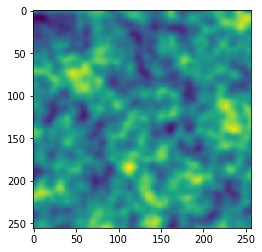

In [6]:
lin = np.linspace(0, 5, HEIGHT_MAP_SIZE, endpoint = False)
x, y = np.meshgrid(lin, lin)

octaves = {
    1: 0.4,
    2: 0.2,
    3: 0.2,
    4: 0.1,
    5: 0.05,    
}

noise_map = sum([w * perlin(i * x, i * y) for i, w in octaves.items()])
plt.imshow(noise_map)

In [7]:
def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

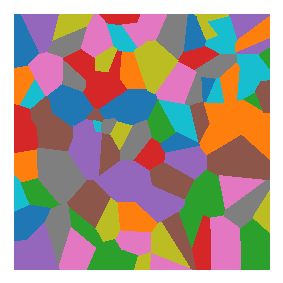

In [8]:
# Generate the random sites of the Voronoi diagram.
np.random.seed(1234)
points = np.random.rand(100, 2)

# Compute the polygons that tesselate the Voronoi diagram.
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# Draw the polygons to a matplotlib figure.
DPI = 100
fig = plt.figure(figsize=(HEIGHT_MAP_SIZE / DPI, HEIGHT_MAP_SIZE / DPI), dpi=DPI)
ax = fig.add_axes([0,0,1,1])
for region in regions:
    polygon = vertices[region]
    ax.fill(*zip(*polygon), aa=False)
ax.set_xlim(vor.min_bound[0], vor.max_bound[0])
ax.set_ylim(vor.min_bound[1], vor.max_bound[1])
ax.axis('off')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [9]:
# Although hacky, we can ge the rasterized pixels by dumping the figure to a file.
fig.savefig("fig.png", bbox_inches="tight", pad_inches=0, dpi=DPI) 
color_map = imageio.imread("fig.png")[4:-3,4:-3,0:3]
os.remove("fig.png")

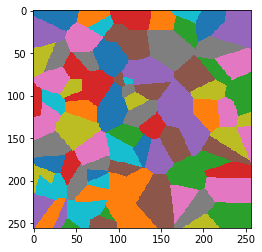

In [10]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

plt.imshow(np.swapaxes(color_map, 0, 1))

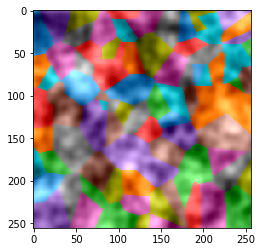

In [11]:
min_noise = noise_map.min()
max_noise = noise_map.max()
noise_map = (noise_map - min_noise) / (max_noise - min_noise)

combined_map = rgb2ycbcr(color_map)
combined_map[:,:,0] = (255 * noise_map).astype(np.uint8)
plt.imshow(ycbcr2rgb(combined_map))

In [12]:
%%time

# Build a 3D-grid of voxel arrays from the heigh map
VOXEL_ARRAY_SIZE = 64

def build_voxel_array(start_x, start_y, start_z):
    va = voxels.VoxelArray()
    va.translate(start_x, start_y, start_z)
    for z in range(start_z, start_z + VOXEL_ARRAY_SIZE):
        for x in range(start_x, start_x + VOXEL_ARRAY_SIZE):
            height = int(20 + 20 * (noise_map[x, z] - 0.5))
            color = color_map[x, z, :].astype(np.uint32)
            rgba = int(color[0] << 24) + (color[1] << 16) + (color[2] << 8)
            for y in range(start_y, height):
                va.set(x - start_x, y - start_y, z - start_z, rgba)
    return va


grid_size = HEIGHT_MAP_SIZE // VOXEL_ARRAY_SIZE
voxel_arrays = {}
for iz in range(grid_size):
    for iy in range(grid_size):
        for ix in range(grid_size):
            print(f"Building array: {(ix, iy, iz)}...")
            voxel_arrays[(ix, iy, iz)] = build_voxel_array(
                ix * VOXEL_ARRAY_SIZE,
                iy * VOXEL_ARRAY_SIZE,
                iz * VOXEL_ARRAY_SIZE,
            )
            

Building array: (0, 0, 0)...
Building array: (1, 0, 0)...
Building array: (2, 0, 0)...
Building array: (3, 0, 0)...
Building array: (0, 1, 0)...
Building array: (1, 1, 0)...
Building array: (2, 1, 0)...
Building array: (3, 1, 0)...
Building array: (0, 2, 0)...
Building array: (1, 2, 0)...
Building array: (2, 2, 0)...
Building array: (3, 2, 0)...
Building array: (0, 3, 0)...
Building array: (1, 3, 0)...
Building array: (2, 3, 0)...
Building array: (3, 3, 0)...
Building array: (0, 0, 1)...
Building array: (1, 0, 1)...
Building array: (2, 0, 1)...
Building array: (3, 0, 1)...
Building array: (0, 1, 1)...
Building array: (1, 1, 1)...
Building array: (2, 1, 1)...
Building array: (3, 1, 1)...
Building array: (0, 2, 1)...
Building array: (1, 2, 1)...
Building array: (2, 2, 1)...
Building array: (3, 2, 1)...
Building array: (0, 3, 1)...
Building array: (1, 3, 1)...
Building array: (2, 3, 1)...
Building array: (3, 3, 1)...
Building array: (0, 0, 2)...
Building array: (1, 0, 2)...
Building array

In [13]:
%%time

# Create a new world DB.
table = data.Table("octree_world")

Wall time: 3.97 ms


In [14]:
%%time

# Dump all of the voxel arrays into the DB.
for (ix, iy, iz), va in voxel_arrays.items():
    index = ix + iy * grid_size + iz * grid_size * grid_size
    table.set(f"voxels/{index}", voxels.dumps(va))

Wall time: 599 ms


In [15]:
%%time

# Create an octree for the world so that we can selectively render based on a camera.
OCTREE_LEAF_SIZE = 32
octree = spatial.Octree(
    OCTREE_LEAF_SIZE,
    HEIGHT_MAP_SIZE // OCTREE_LEAF_SIZE,
)

for cell in range(len(octree)):
    table.set(f"cell_config/{cell}/voxels", json.dumps({"voxel_keys": []}))
    
for (ix, iy, iz), va in voxel_arrays.items():
    va_index = ix + iy * grid_size + iz * grid_size * grid_size
    va_key = f"voxels/{va_index}"
    cells = octree.intersect_box((
        ix * VOXEL_ARRAY_SIZE,
        iy * VOXEL_ARRAY_SIZE,
        iz * VOXEL_ARRAY_SIZE,
        (ix + 1) * VOXEL_ARRAY_SIZE,
        (iy + 1) * VOXEL_ARRAY_SIZE,
        (iz + 1) * VOXEL_ARRAY_SIZE,
    ))
    for cell in cells:
        table_key = f"cell_config/{cell}/voxels" 
        voxel_config = json.loads(table.get(table_key))
        voxel_config["voxel_keys"].append(va_key)
        table.set(table_key, json.dumps(voxel_config))
        
table.set("octree_config", json.dumps({
    "leaf_size": OCTREE_LEAF_SIZE,
    "grid_size": HEIGHT_MAP_SIZE // OCTREE_LEAF_SIZE,
}))

Wall time: 11.5 s


In [16]:
table.get("octree_config")

b'{"leaf_size": 32, "grid_size": 8}'